In [2]:
!pip install qiskit

In [3]:
!pip install qiskit-aer

In [1]:
# qiskit tools for quantum circuit construction, visualization and simulation
# from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer # Import Aer from qiskit_aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# utilities
from operator import attrgetter, itemgetter
from scipy.spatial.distance import cityblock
from heapq import nlargest
import numpy as np

In [3]:
class Target:
    def __init__(self, name, x, y): # no indetermination in the target's position
        self.name = name
        self.x = x
        self.y = y

In [5]:
T = Target("T", 0.875, 0.125) # deep in the ocean

In [7]:
def reward(T, betax, betay):
    return 1 - (((T.x - betax)**2 + (T.y - betay)**2)**0.5)/np.sqrt(2) # distance is normalized on sqrt(2)

In [9]:
class Obstacle:
    _registry = []

    def __init__(self, name, x, y):
        self._registry.append(self)
        self.name = name
        self.x = x
        self.y = y

In [11]:
O = Obstacle("Oo", 0.125, 0.125)

In [13]:
# utility function that returns the complementary amplitude
# of ampl, evaluated as sqrt(1 - ||ampl||^2)
#
def c_ampl(ampl):
    return np.sqrt(1 - ampl**2)

In [15]:
class Robotx(object):
    _registry = []

    def __init__(self, name, alphax, alphay):
        self._registry.append(self)
        self.name = name
        self.alphax = alphax
        self.betax = c_ampl(alphax)
        self.alphay = alphay
        self.betay = c_ampl(alphay)
        self.delta = reward(T, self.betax, self.betay)
        self.gamma = c_ampl(self.delta)

In [17]:
# arbitrary number of robots that, at the start, are uniformly distributed
# in the square of side length radius*2, centered in starting_cluster_coord
#
num_of_robots = 10

# must be lower than 0.25, otherwise, the robots would start on different cells
radius = 0.05

# center of the (0,0) cell
starting_cluster_coord = (0.125, 0.875)

# boundaries to compute the initial random scattering on
a_x, a_y = c_ampl(starting_cluster_coord[0]-radius), c_ampl(starting_cluster_coord[0]+radius)
b_x, b_y = c_ampl(starting_cluster_coord[1]-radius), c_ampl(starting_cluster_coord[1]+radius)

# robots' initialization
for i in range(num_of_robots):
    Robotx('R'+str(i), np.random.uniform(a_x,a_y), np.random.uniform(b_x,b_y))

In [19]:
# note: values are stored with full precision, rounding is done only on visualization (with :.2f)
for k in Robotx._registry:
    print(f"{k.name} {k.betax:.2f} {k.betay:.2f} {k.gamma:.2f} {k.delta:.2f}")

R0 0.14 0.90 0.97 0.25
R1 0.13 0.89 0.97 0.25
R2 0.12 0.84 0.96 0.27
R3 0.11 0.83 0.97 0.26
R4 0.17 0.89 0.96 0.26
R5 0.11 0.88 0.97 0.24
R6 0.15 0.90 0.97 0.25
R7 0.14 0.88 0.97 0.25
R8 0.11 0.85 0.97 0.25
R9 0.15 0.90 0.97 0.25


In [21]:
def calculate_avg_reward():
    rewards = [robot.delta for robot in Robotx._registry]
    return np.mean(rewards)

print(f"Average reward: {calculate_avg_reward()}")

Average reward: 0.252403176487841


In [23]:
# this utility function generates the visualization of the environment with each of the entitites;
# the map is maked with a squared lattice, so as to outline the micro-cell subdivision and the robots
# obstacles, and target are color coded in the followig way:
#   robots: green circle;
#   obstacles: red pentagon;
#   target: turquoise star.
#
def plot_scatterplot(*args):

    # to print grid on map
    ax = plt.figure().gca()
    ax.set_xticks(np.arange(0, 1, 0.25))
    ax.set_yticks(np.arange(0, 1, 0.25))
    plt.grid()

    for i in Robotx._registry:
        # color gradient to better visualize the different robots within the map;
        # the higher the i-th index of the robot's name, the darker the green gradient.
        robot_color = hex(int("0x30ca15", 16) + int("0x00bb00", 16)*int(i.name[1])).replace("0x","#")
        plt.scatter(i.betax, i.betay, s = 300, marker = 'o', color = robot_color)

    plt.scatter(T.x, T.y, s = 400, marker = '*', color = 'turquoise')

    for o in Obstacle._registry:
        plt.scatter(o.x, o.y, s = 400, marker = 'p', color = 'red')

    plt.axis([0, 1, 0, 1])

    if args:
        plt.title(args[0])

    plt.show()

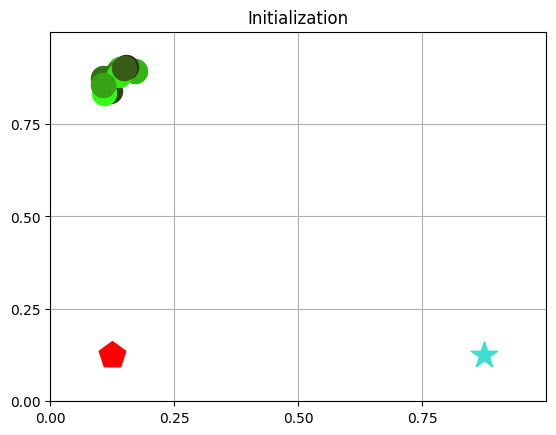

In [25]:
plot_scatterplot("Initialization")

In [26]:
for r in Robotx._registry:
    if (r.delta < 0.5):
        print(f"{r.name} {r.delta:.2f} achtung!") # and start from this point to build the reshuffle section

R0 0.25 achtung!
R1 0.25 achtung!
R2 0.27 achtung!
R3 0.26 achtung!
R4 0.26 achtung!
R5 0.24 achtung!
R6 0.25 achtung!
R7 0.25 achtung!
R8 0.25 achtung!
R9 0.25 achtung!


In [29]:
# returns a dict so that:
#  - the keys are the coordinates of the centroids of a square dim_map x dim_map map of side length 1
#  - the values are in the form (micro_cell, macro_cell) of the centroids
def find_centroids(dim_map):

    unit_displacement = 1 / (dim_map*2)

    centroids_coords = []
    for i in range(dim_map,0,-1):
        row = []
        for j in range(dim_map):
            row.append((j*unit_displacement*2 + unit_displacement, i*unit_displacement*2 - unit_displacement))
        centroids_coords.append(row)

    centroids_dict = {t: (f"{str(i%2)}{str(j%2)}", f"{0 if t[1] > 0.5 else 1}{0 if t[0] < 0.5 else 1}")
     for i,row in enumerate(centroids_coords) for j,t in enumerate(row)}

    return centroids_dict

In [31]:
centroids = find_centroids(4)
print("Centroids:\n{ " + "\n  ".join(f"{k}: {v} " for k, v in centroids.items()) + "}")

Centroids:
{ (0.125, 0.875): ('00', '00') 
  (0.375, 0.875): ('01', '00') 
  (0.625, 0.875): ('00', '01') 
  (0.875, 0.875): ('01', '01') 
  (0.125, 0.625): ('10', '00') 
  (0.375, 0.625): ('11', '00') 
  (0.625, 0.625): ('10', '01') 
  (0.875, 0.625): ('11', '01') 
  (0.125, 0.375): ('00', '10') 
  (0.375, 0.375): ('01', '10') 
  (0.625, 0.375): ('00', '11') 
  (0.875, 0.375): ('01', '11') 
  (0.125, 0.125): ('10', '10') 
  (0.375, 0.125): ('11', '10') 
  (0.625, 0.125): ('10', '11') 
  (0.875, 0.125): ('11', '11') }


In [33]:
# returns the centroid tuple of the cell that a point of coordinates (x,y) is located in
def find_closest_centroid(centroids, x, y):
    centroids_coords = np.array(list(centroids.keys()))
    distances = np.linalg.norm(centroids_coords-np.array([x, y]), axis=1)
    return centroids[tuple(centroids_coords[np.argmin(distances)])]

In [35]:
for r in Robotx._registry:
    print(f"Closest centroid to {r.name}: {find_closest_centroid(centroids, r.betax, r.betay)}")

Closest centroid to R0: ('00', '00')
Closest centroid to R1: ('00', '00')
Closest centroid to R2: ('00', '00')
Closest centroid to R3: ('00', '00')
Closest centroid to R4: ('00', '00')
Closest centroid to R5: ('00', '00')
Closest centroid to R6: ('00', '00')
Closest centroid to R7: ('00', '00')
Closest centroid to R8: ('00', '00')
Closest centroid to R9: ('00', '00')


In [37]:
# associate centroids to obstacles
obstacles_centroids = {coord: v for (coord,v) in centroids.items() for o in Obstacle._registry if coord == (o.x, o.y)}
print("Obstacles' centroids:\n{ " + "\n  ".join(f"{k}: {v} " for k, v in obstacles_centroids.items()) + "}")

Obstacles' centroids:
{ (0.125, 0.125): ('10', '10') }


In [39]:
# takes as input strings with the binary encoding of cells and outputs the manhattan distance between them
def manhattan(start_cell, target_cell):
    start_cell_v, target_cell_v = [int(b) for b in start_cell], [int(b) for b in target_cell]
    return int(cityblock(start_cell_v, target_cell_v).item())

In [41]:
class GroverPlanner:
    def __init__(self, obstacles):
        self.simulator = Aer.get_backend("aer_simulator")
        self.obstacles = obstacles

    #
    # Utility functions
    #
    def XOR(self, qc, a, b, output):
        qc.cx(a, output)
        qc.cx(b, output)

    def encode_cell(self, qc, cell, qubits):
        for idx, bit in enumerate(cell):
            bitn = int(bit)
            if bitn:
                qc.x(qubits[idx])

    def encode_target(self, qc, target_cell, qubits):
        for idx, bit in enumerate(target_cell):
            bitn = int(bit)
            if not bitn:
                qc.x(qubits[idx])

    def obstacles_in_map(self, target_cell):
        return any(target_cell[1] == macro_cell for macro_cell in list(map(lambda ob_t: ob_t[1], self.obstacles)))

    #
    # Grover diffuser
    #
    def diffuser(self, nqubits):
        diff = QuantumCircuit(nqubits)

        # Apply transformation |s> -> |00..0> (H-gates)
        for qubit in range(nqubits):
            diff.h(qubit)

        # Apply transformation |00..0> -> |11..1> (X-gates)
        for qubit in range(nqubits):
            diff.x(qubit)

        # Do multi-controlled-Z gate
        diff.h(nqubits - 1)
        # Use mcx with mode='noancilla' for multi-controlled Toffoli
        diff.mcx(list(range(nqubits - 1)), nqubits - 1, mode='noancilla')
        diff.h(nqubits - 1)

        # Apply transformation |11..1> -> |00..0>
        for qubit in range(nqubits):
            diff.x(qubit)

        # Apply transformation |00..0> -> |s>
        for qubit in range(nqubits):
            diff.h(qubit)

        U_s = diff.to_gate()
        U_s.name = "U$_\psi$"
        return U_s

    #
    # Half oracle
    #
    # it performs the quantum moves to get to the final state the solution test is performed on; its structure
    # changes according to both the number of movements required to get to the target and the presence of obstacles
    #
    def half_oracle(self, num_of_M, obstacles_in_map, quantum_registers):

        if num_of_M == 1:

            ho = QuantumCircuit(*quantum_registers)
            pos_qubits, mov_qubits, c, output = quantum_registers

            # -- First M --
            self.XOR(ho, pos_qubits[1], mov_qubits[0], c[0])
            ho.x(c[0])
            self.XOR(ho, pos_qubits[0], mov_qubits[0], c[1])

        elif num_of_M == 2:

            ho = QuantumCircuit(*quantum_registers)

            if obstacles_in_map:
                pos_qubits, mov_qubits, c, o, caux, out, output = quantum_registers
            else:
                pos_qubits, mov_qubits, c, output = quantum_registers

            # -- First M --
            self.XOR(ho, pos_qubits[1], mov_qubits[0], c[0])
            ho.x(c[0])
            self.XOR(ho, pos_qubits[0], mov_qubits[0], c[1])

            if obstacles_in_map:
                # -- Obstacle encoding --
                for obstacle in self.obstacles:
                    self.encode_cell(ho, obstacle[0], [c[0], c[1]])
                    ho.ccx(c[0], c[1], o)
                    self.encode_cell(ho, obstacle[0], [c[0], c[1]])

            # -- Second M --
            self.XOR(ho, c[1], mov_qubits[1], c[2])
            ho.x(c[2])
            self.XOR(ho, c[0], mov_qubits[1], c[3])

            if obstacles_in_map:
                # -- Selection stage --
                ho.ccx(c[2], o, caux[0])
                ho.x(caux[0])
                ho.ccx(c[3], o, caux[1])
                ho.x(caux[1])

                ho.x(o)

                ho.ccx(pos_qubits[0], o, caux[2])
                ho.x(caux[2])
                ho.ccx(pos_qubits[1], o, caux[3])
                ho.x(caux[3])

                ho.ccx(caux[0], caux[2], out[0])
                ho.x(out[0])
                ho.ccx(caux[1], caux[3], out[1])
                ho.x(out[1])

        HalfOracle = ho.to_gate()
        HalfOracle.name = "HO"
        return HalfOracle

    #
    # Grover oracle
    #
    # it is composed of a oracle half, the testing operator, and the mirror circuit of the first half
    #
    def oracle(self, num_of_M, target_cell, m_type, obstacles_in_map, qc, quantum_registers):

        halforacle = self.half_oracle(num_of_M, obstacles_in_map, quantum_registers)

        additional_regs = []

        if obstacles_in_map:
            pos_qubits, mov_qubits, c, *additional_regs, output = quantum_registers
        else:
            pos_qubits, mov_qubits, c, output = quantum_registers

        # -- First half of the oracle --
        qc.append(
            halforacle,
            pos_qubits[:]
            + mov_qubits[:]
            + c[:]
            + (
                (additional_regs[0][:] + additional_regs[1][:] + additional_regs[2][:])
                if additional_regs
                else []
            )
            + output[:],
        )

        # -- Test operator --
        test_qubits = c[-2:] if num_of_M == 1 or (num_of_M == 2 and not obstacles_in_map) else additional_regs[2]
        tcell_idx = 0 if m_type == "micro" else 1
        self.encode_target(qc, target_cell[tcell_idx], [test_qubits[0], test_qubits[1]])
        qc.ccx(test_qubits[0], test_qubits[1], output)
        self.encode_target(qc, target_cell[tcell_idx], [test_qubits[0], test_qubits[1]])

        # -- Mirror circuit of the first half of the oracle --
        qc.append(
            halforacle.inverse(),
            pos_qubits[:]
            + mov_qubits[:]
            + c[:]
            + (
                (additional_regs[0][:] + additional_regs[1][:] + additional_regs[2][:])
                if additional_regs
                else []
            )
            + output[:],
        )

    #
    # Path planning
    #
    # takes as input the tuples of centroids start_cell and target_cell, together with the movement type (m_type),
    # that can yield the values "micro" or "macro"
    #
    def find_path(self, start_cell, target_cell, m_type):

        # number of M operators is equal to the Manhattan distance between start and target
        cell_idx = 0 if m_type == "micro" else 1
        num_of_M = manhattan(start_cell[cell_idx], target_cell[cell_idx])

        # --- Initializations ---
        pos_qubits = QuantumRegister(2, name="r")
        mov_qubits = QuantumRegister(num_of_M, name="m")
        c = QuantumRegister(2 * num_of_M, name="c")

        o = QuantumRegister(1, name="o")
        caux = QuantumRegister(4, name="caux")
        out = QuantumRegister(2, name="out")

        output = QuantumRegister(1, name="q")
        cbits = ClassicalRegister(2 + num_of_M, name="cbits")

        # check if there are obstacles to be considered within the path
        obstacles_in_map = self.obstacles_in_map(target_cell) and m_type == "micro"

        # ensemble of quantum registers to build the QuantumCircuit with
        base_registers = [pos_qubits, mov_qubits, c, output, cbits]
        additional_registers = base_registers.copy()
        additional_registers[3:3] = [o, caux, out]
        quantum_registers = (
            base_registers
            if num_of_M == 1 or (num_of_M == 2 and not obstacles_in_map)
            else additional_registers
        )

        qc = QuantumCircuit(*quantum_registers)

        # initialize pos_qubits in uniform superposition
        qc.h(pos_qubits)

        # initialize mov_qubits in state |s>
        qc.h(mov_qubits)

        # initialize 'output0' in state |->
        qc.initialize([1, -1] / np.sqrt(2), output)

        # --- Oracle + Diffuser ---
        num_iterations = 1
        for _ in range(num_iterations):
            self.oracle(
                num_of_M,
                target_cell,
                m_type,
                obstacles_in_map,
                qc,
                quantum_registers[:-1],
            )
            diff_qubits = [0, 1, 2] if num_of_M == 1 else list(range(2 + num_of_M))
            qc.append(self.diffuser(len(diff_qubits)), diff_qubits)

        # --- Measurement ---
        qc.measure(pos_qubits, cbits[0:2])
        qc.measure(mov_qubits, cbits[2 : (2 + num_of_M)])

        # --- Simulation ---
        transpiled_qc = transpile(qc, self.simulator)
        result_counts = self.simulator.run(transpiled_qc).result().get_counts()

        # filtering out all the non-trivial solutions on the simulation output
        return [k for k in result_counts.keys() if k[-2:] == start_cell[cell_idx][len(start_cell[cell_idx]) :: -1]]

groverPlanner = GroverPlanner(obstacles_centroids.values())

<>:57: SyntaxWarning: invalid escape sequence '\p'
<>:57: SyntaxWarning: invalid escape sequence '\p'
/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_88022/3027027379.py:57: SyntaxWarning: invalid escape sequence '\p'
  U_s.name = "U$_\psi$"


In [43]:
# test
groverPlanner.find_path(start_cell=("00", "00"), target_cell=("00", "01"), m_type="macro")

/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_88022/3027027379.py:57: SyntaxWarning: invalid escape sequence '\p'
  U_s.name = "U$_\psi$"


NameError: name 'QuantumRegister' is not defined

In [45]:
# returns a list with the micro and macro displacement after the movement
def eval_displacement(old_centroid, new_centroid):
    old_c_micro, old_c_macro = old_centroid
    new_c_micro, new_c_macro = new_centroid
    return [manhattan(old_c_micro, new_c_micro), manhattan(old_c_macro, new_c_macro)]

In [47]:
# computes the movements required to get to the position encoded in new_alphas, which has the form [new_alphax, new_alphay]
#
# it also updates the new position of the robot, so there is no need to do that separately
#
def compute_path_to_position(robot, new_alphas):

    # starting centroid
    old_centroid = find_closest_centroid(centroids, robot.betax, robot.betay)

    # assign new positions
    robot.alphax, robot.alphay = new_alphas
    robot.betax, robot.betay = c_ampl(robot.alphax), c_ampl(robot.alphay)

    # new centroid
    new_centroid = find_closest_centroid(centroids, robot.betax, robot.betay)

    # displacement between the new and starting centroids
    displacement = eval_displacement(old_centroid, new_centroid)

    #
    # Planning the path according to the different possible displacement:
    #   - macro: the robot changes macro-cell but stays in the same micro-cell
    #   - micro: the robot changes micro-cell but stays in the same macro-cell
    #   - macro and micro: the robot changes both macro and micro cells
    #   - if the new position is in the same micro and macro cells nothing happens
    #

    # --- Macro movement ---
    if displacement[0] == 0 and displacement[1] != 0:
        print(f"{robot.name}: macro")
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="macro")
        print(f"{robot.name} evaluated path: {evaluated_path[0][:-2]}")

    # --- Micro movement ---
    elif displacement[0] != 0 and displacement[1] == 0:
        print(f"{robot.name}: micro")
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="micro")
        print(f"{robot.name} evaluated path: {evaluated_path[0][:-2]}")

    # --- Macro and micro movement ---
    elif displacement[0] != 0 and displacement[1] != 0:
        print(f"{robot.name}: macro-micro")
        # macro path
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="macro")
        print(f"{robot.name} evaluated path (macro): {evaluated_path[0][:-2]}")

        # micro path
        evaluated_path = groverPlanner.find_path(old_centroid, new_centroid, m_type="micro")
        print(f"{robot.name} evaluated path (micro): {evaluated_path[0][:-2]}")

In [49]:
# check whether a given position ends up in a obstacle cell
def is_position_on_obstacle(new_alphas):
    new_pos_centroid = find_closest_centroid(centroids, c_ampl(new_alphas[0]), c_ampl(new_alphas[1]))
    return True if new_pos_centroid in obstacles_centroids.values() else False

In [51]:
def informed_alpha_reshuffling():

    # parse the coordinates of farthest robot from the target
    #
    # since this method is called when the robots are in a cluster (either at the start or ar the end
    # of a full procedure), it does not matter which robot is chosen, all being quite close to each other;
    # here, among all, I am choosing the farthest one with the idea of "maximum coverage" of the search space
    #
    farthest_robot = min(Robotx._registry, key=attrgetter('delta'))
    f_centroid = find_closest_centroid(centroids, farthest_robot.betax, farthest_robot.betay)
    f_coords = list(list(centroids.keys())[list(centroids.values()).index(f_centroid)])

    # handle the case where the robot lies in the same row/column of the target
    if f_coords[0] == T.x:
        f_coords[0] = f_coords[1]
    elif f_coords[1] == T.y:
        f_coords[1] = f_coords[0]

    # compute the new reshuffled position within the rectangle
    return [c_ampl(np.random.uniform(f_coords[0], T.x)), c_ampl(np.random.uniform(f_coords[1], T.y))]

In [53]:
result = all(i.delta < 0.8 for i in Robotx._registry)
print("Do all the robots have a reward lower than 0.8? : " + str(result))

# if True: reshuffle positions
# if False: do nothing

# reshuffling is considered invalid if the target position of the robot is the same as that of an obstacle;
# with this consideration, no computational time is wasted trying to find the path to an inaccessible cell

if result == True:
    for i in Robotx._registry:
        new_alphas = informed_alpha_reshuffling()

        # if new position ends up in an obstacle cell, recompute the alphas
        while is_position_on_obstacle(new_alphas):
            new_alphas = informed_alpha_reshuffling()

        compute_path_to_position(i, new_alphas)

Do all the robots have a reward lower than 0.8? : True
R0: micro


NameError: name 'QuantumRegister' is not defined

In [55]:
# recalculate the rewards
def recalculate_rewards():
    for i in Robotx._registry:
        i.delta = reward(T, i.betax, i.betay)
        i.gamma = c_ampl(i.delta)
        print(f"{i.name} {i.delta:.2f}")

In [57]:
recalculate_rewards()
print(f"Average reward: {calculate_avg_reward()}")

R0 0.43
R1 0.25
R2 0.27
R3 0.26
R4 0.26
R5 0.24
R6 0.25
R7 0.25
R8 0.25
R9 0.25
Average reward: 0.27086121370212235


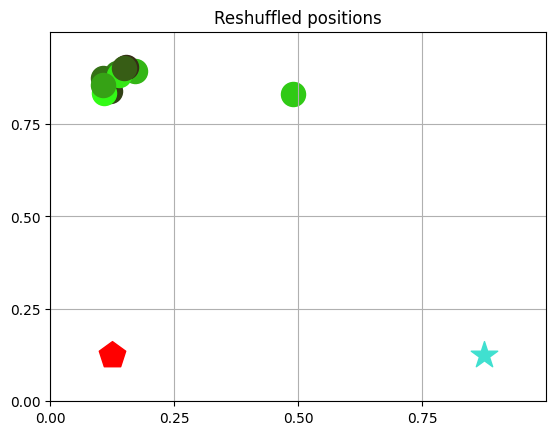

In [59]:
plot_scatterplot("Reshuffled positions")

### 5.1 Circuit construction and execution

In [62]:
q = QuantumRegister(5, 'q') # qubits # changed to 9, formerly 15
m2 = ClassicalRegister(1, 'c1') # classical bits (separated is better)
m3 = ClassicalRegister(1, 'c2')
m4 = ClassicalRegister(1, 'c3')
meas = ClassicalRegister(3, 'meas')

qc3 = QuantumCircuit(q, m2, m3, m4) # to reach the target
qc4 = QuantumCircuit(q, m2, m3, m4) # to get back to the nest

NameError: name 'QuantumRegister' is not defined

In [64]:
# utility function to better visualize the statevectors we are working with
def print_formatted_vector(*args):
    for vector in args:
        print("[" + "".join(f"{val:.2f} " for val in vector).strip() + "]")

In [66]:
# in case of ties on delta score, the max() function outputs the first maximum item it processes
closest_robot = max(Robotx._registry, key=attrgetter('delta'))
print(f"Closest robot to the target: {closest_robot.name} {closest_robot.betax:.2f} {closest_robot.betay:.2f} {closest_robot.delta:.2f}")

# and then it enters the gate
vector0 = [closest_robot.alphax, closest_robot.betax]
vector1 = [closest_robot.alphay, closest_robot.betay]
vector3 = [closest_robot.gamma, closest_robot.delta]

normalized_v0 = vector0/np.linalg.norm(vector0)
normalized_v1 = vector1/np.linalg.norm(vector1)
normalized_v3 = vector3/np.linalg.norm(vector3)

print_formatted_vector(vector0, vector1, vector3)
print_formatted_vector(normalized_v0, normalized_v1, normalized_v3)

Closest robot to the target: R0 0.49 0.83 0.43
[0.87 0.49]
[0.56 0.83]
[0.90 0.43]
[0.87 0.49]
[0.56 0.83]
[0.90 0.43]


In [68]:
# direct initialization with amplitudes vector
qc3.initialize(normalized_v0, q[0])
qc3.initialize(normalized_v1, q[1])
qc3.initialize(normalized_v3, q[2])

NameError: name 'qc3' is not defined

In [70]:
!pip install pylatexenc

In [71]:
# this is the core code, and it is unchanged across time
#
qc3.barrier(q)

qc3.ccx(q[0],q[2],q[3])
qc3.ccx(q[1],q[2],q[4])

qc3.x(q[2])

qc3.ch(q[2],q[3])
qc3.ch(q[2],q[4])

qc3.x(q[2])

qc3.barrier(q)

# perform measurements and store them in classical bits
qc3.measure(q[2],m2[0])
qc3.measure(q[3],m3[0])
qc3.measure(q[4],m4[0])

# visualization of the ciruit
qc3.draw(output="mpl")

NameError: name 'qc3' is not defined

In [93]:
# --- Simulation ---
aer_sim = Aer.get_backend("aer_simulator")
transpiled_qc = transpile(qc3, aer_sim)
result = aer_sim.run(transpiled_qc).result()

counts = result.get_counts()
print("counts: ", counts)

plot_histogram(result.get_counts())

NameError: name 'transpile' is not defined

In [95]:
# calculate weighted outcome on the most probables outcomes of the circuit
def eval_outcome(most_prob_dict, n_outcome):
    mapped_weights = list(map(lambda res: int(res[n_outcome*2])*most_prob_dict[res], most_prob_dict))
    return sum(mapped_weights)/sum(most_prob_dict.values())

In [97]:
num_most_prob_states = 4

# extract the most probable states and then evaluate the outcome
most_prob_dict = dict(nlargest(num_most_prob_states, counts.items(), key=itemgetter(1)))
print(f"{num_most_prob_states} most probable states: {most_prob_dict}")

outcome0, outcome1 = eval_outcome(most_prob_dict, 0), eval_outcome(most_prob_dict, 1)

print(f"outcome0: {outcome0:.2f}\noutcome1: {outcome1:.2f}")

NameError: name 'counts' is not defined

In [99]:
for i in Robotx._registry:
    print(f"{i.name} {i.betax:.2f} {i.betay:.2f}")
    if (i.delta != closest_robot.delta or all(i.delta == j.delta for j in Robotx._registry)): # excluding the robot that entered the gate
        compute_path_to_position(i, [c_ampl(outcome1), c_ampl(outcome0)]) # update on alphas is done within the function

R0 0.49 0.83
R1 0.13 0.89


NameError: name 'outcome1' is not defined

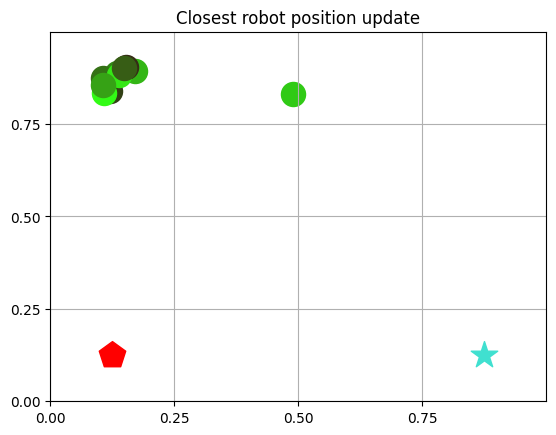

In [101]:
plot_scatterplot("Closest robot position update")

In [103]:
# former rewards
for i in  Robotx._registry:
    print(f"before the gate: {i.name} {i.delta:.2f}")

before the gate: R0 0.43
before the gate: R1 0.25
before the gate: R2 0.27
before the gate: R3 0.26
before the gate: R4 0.26
before the gate: R5 0.24
before the gate: R6 0.25
before the gate: R7 0.25
before the gate: R8 0.25
before the gate: R9 0.25


In [105]:
# new rewards
recalculate_rewards()
print(f"Average reward: {calculate_avg_reward()}")

R0 0.43
R1 0.25
R2 0.27
R3 0.26
R4 0.26
R5 0.24
R6 0.25
R7 0.25
R8 0.25
R9 0.25
Average reward: 0.27086121370212235


In [107]:
# parse the most successful robot
max_attr_ = max(Robotx._registry, key=attrgetter('delta'))
print(f"max_attr_.delta: {max_attr_.delta:.2f}")

for i in Robotx._registry:
    if (i.delta == max_attr_.delta):
        print(f"Most successful robot: {i.name} {i.betax:.2f} {i.betay:.2f} {i.delta:.2f}") # and then it enters the gate

for j in Robotx._registry:
    # to get other robots following it:
    if (j != max_attr_):
        compute_path_to_position(j, [max_attr_.alphax + np.random.uniform(0,0.01), max_attr_.alphay + np.random.uniform(0,0.01)])

max_attr_.delta: 0.43
Most successful robot: R0 0.49 0.83 0.43
R1: micro


NameError: name 'QuantumRegister' is not defined

In [109]:
recalculate_rewards()
print(f"Average reward: {calculate_avg_reward()}")

R0 0.43
R1 0.43
R2 0.27
R3 0.26
R4 0.26
R5 0.24
R6 0.25
R7 0.25
R8 0.25
R9 0.25
Average reward: 0.2890046699507848


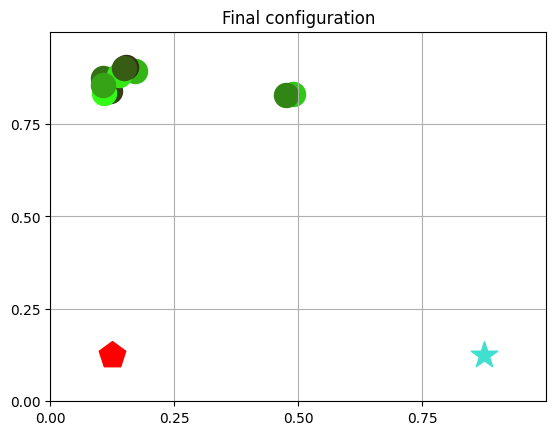

In [111]:
plot_scatterplot("Final configuration")

In [113]:
for i in Robotx._registry:
    if (i.delta < 0.8):

        new_alphas = informed_alpha_reshuffling()

        # if new position ends up in an obstacle cell, recompute the alphas
        while is_position_on_obstacle(new_alphas):
                new_alphas = informed_alpha_reshuffling()

        compute_path_to_position(i, new_alphas)

R0: macro


NameError: name 'QuantumRegister' is not defined

In [115]:
recalculate_rewards()

R0 0.65
R1 0.43
R2 0.27
R3 0.26
R4 0.26
R5 0.24
R6 0.25
R7 0.25
R8 0.25
R9 0.25


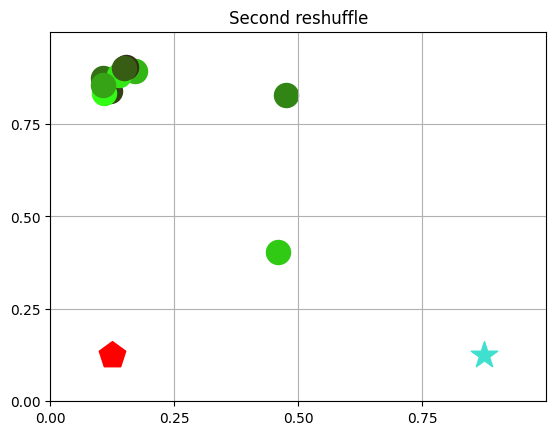

In [117]:
plot_scatterplot("Second reshuffle")

In [119]:
# parse the most successful robot
max_attr_ = max(Robotx._registry, key=attrgetter('delta'))
print(f"max_attr_.delta: {max_attr_.delta:.2f}")

for i in Robotx._registry:
    if (i.delta == max_attr_.delta):
        print(f"Most successful robot: {i.name} {i.betax:.2f} {i.betay:.2f} {i.delta:.2f}") # and then it enters the gate

for j in Robotx._registry:
    # to get other robots following it:
    if (j != max_attr_):
        compute_path_to_position(j, [max_attr_.alphax + np.random.uniform(0,0.01), max_attr_.alphay + np.random.uniform(0,0.01)])

max_attr_.delta: 0.65
Most successful robot: R0 0.46 0.40 0.65
R1: macro


NameError: name 'QuantumRegister' is not defined

In [121]:
recalculate_rewards()

R0 0.65
R1 0.64
R2 0.27
R3 0.26
R4 0.26
R5 0.24
R6 0.25
R7 0.25
R8 0.25
R9 0.25


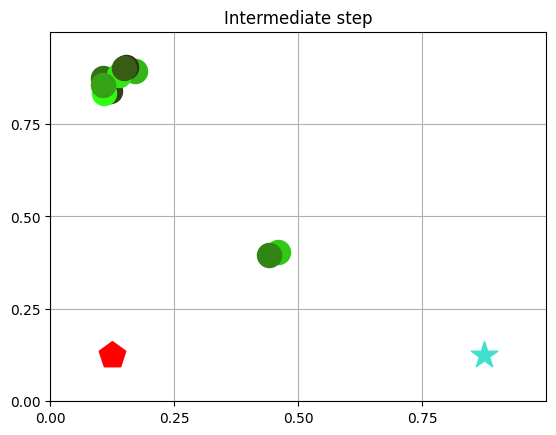

In [123]:
plot_scatterplot("Intermediate step")

Here, the quantum swarm algorithm is invoked yet another time.

In [126]:
# in case of ties on delta score, the max() function outputs the first maximum item it processes
closest_robot = max(Robotx._registry, key=attrgetter('delta'))
print(f"Closest robot to the target: {closest_robot.name} {closest_robot.betax:.2f} {closest_robot.betay:.2f} {closest_robot.delta:.2f}")

# and then it enters the gate
vector0 = [closest_robot.alphax, closest_robot.betax]
vector1 = [closest_robot.alphay, closest_robot.betay]
vector3 = [closest_robot.gamma, closest_robot.delta]

normalized_v0 = vector0/np.linalg.norm(vector0)
normalized_v1 = vector1/np.linalg.norm(vector1)
normalized_v3 = vector3/np.linalg.norm(vector3)

print_formatted_vector(vector0, vector1, vector3)
print_formatted_vector(normalized_v0, normalized_v1, normalized_v3)

Closest robot to the target: R0 0.46 0.40 0.65
[0.89 0.46]
[0.91 0.40]
[0.76 0.65]
[0.89 0.46]
[0.91 0.40]
[0.76 0.65]


In [128]:
# direct initialization with amplitudes vector
qc3.initialize(normalized_v0, q[0])
qc3.initialize(normalized_v1, q[1])
qc3.initialize(normalized_v3, q[2])

NameError: name 'qc3' is not defined

In [130]:
# this is the core code, and it is unchanged across time

qc3.barrier(q)

qc3.ccx(q[0],q[2],q[3])
qc3.ccx(q[1],q[2],q[4])

qc3.x(q[2])

qc3.ch(q[2],q[3])
qc3.ch(q[2],q[4])

qc3.x(q[2])

qc3.barrier(q)

NameError: name 'qc3' is not defined

In [132]:
# perform measurements and store them in classical bits

qc3.measure(q[2],m2[0])
qc3.measure(q[3],m3[0])
qc3.measure(q[4],m4[0])

NameError: name 'qc3' is not defined

In [134]:
# --- Simulation ---
transpiled_qc = transpile(qc3, aer_sim)
result = aer_sim.run(transpiled_qc).result()

counts = result.get_counts()
print("counts: ", counts)

plot_histogram(result.get_counts())

NameError: name 'transpile' is not defined

In [136]:
# extract the most probable states and then evaluate the outcome
most_prob_dict = dict(nlargest(num_most_prob_states, counts.items(), key=itemgetter(1)))
print(f"{num_most_prob_states} most probable states: {most_prob_dict}")

outcome0, outcome1 = eval_outcome(most_prob_dict, 0), eval_outcome(most_prob_dict, 1)

print(f"outcome0: {outcome0:.2f}\noutcome1: {outcome1:.2f}")

NameError: name 'counts' is not defined

In [138]:
for i in Robotx._registry:
    print(f"{i.name} {i.betax:.2f} {i.betay:.2f}")
    if (i.delta != closest_robot.delta or all(i.delta == j.delta for j in Robotx._registry)): # excluding the robot that entered the gate
        compute_path_to_position(i, [c_ampl(outcome1), c_ampl(outcome0)]) # update on alphas is done within the function

R0 0.46 0.40
R1 0.44 0.40


NameError: name 'outcome1' is not defined

In [140]:
# former rewards
for i in  Robotx._registry:
    print(f"before the gate: {i.name} {i.delta:.2f}")

before the gate: R0 0.65
before the gate: R1 0.64
before the gate: R2 0.27
before the gate: R3 0.26
before the gate: R4 0.26
before the gate: R5 0.24
before the gate: R6 0.25
before the gate: R7 0.25
before the gate: R8 0.25
before the gate: R9 0.25


In [142]:
# new rewards
print("Rewards after the gate: ")
recalculate_rewards()

Rewards after the gate: 
R0 0.65
R1 0.64
R2 0.27
R3 0.26
R4 0.26
R5 0.24
R6 0.25
R7 0.25
R8 0.25
R9 0.25


In [144]:
# parse the most successful robot
max_attr_ = max(Robotx._registry, key=attrgetter('delta'))
print(f"max_attr_.delta: {max_attr_.delta:.2f}")

for i in Robotx._registry:
    if (i.delta == max_attr_.delta):
        print(f"Most successful robot: {i.name} {i.betax:.2f} {i.betay:.2f} {i.delta:.2f}") # and then it enters the gate

for j in Robotx._registry:
    # to get other robots following it:
    if (j != max_attr_):
        compute_path_to_position(j, [max_attr_.alphax + np.random.uniform(0,0.01), max_attr_.alphay + np.random.uniform(0,0.01)])

max_attr_.delta: 0.65
Most successful robot: R0 0.46 0.40 0.65
R2: macro-micro


NameError: name 'QuantumRegister' is not defined

In [146]:
recalculate_rewards()

R0 0.65
R1 0.64
R2 0.64
R3 0.26
R4 0.26
R5 0.24
R6 0.25
R7 0.25
R8 0.25
R9 0.25


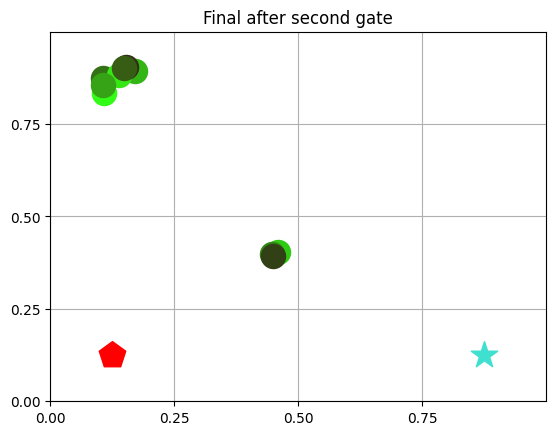

In [148]:
plot_scatterplot("Final after second gate")